# Teste de Performance 3

Engenharia de Prompts para Ciência de Dados

Pedro Monteiro Vieira Bayma Azevedo

## Imports

In [1]:
import os
import json
import requests
from bs4 import BeautifulSoup as bs
import google.generativeai as genai 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from dotenv import load_dotenv
from services.functions import *
import tiktoken

/Users/pedromonteiro/Library/Mobile Documents/com~apple~CloudDocs/Faculdade/promptClass/TP3/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#loading api key

load_dotenv('.env')

True

## Questão 1

![Q1](./images/Q1.png)

O resultado veio de acordo com o esperado, com uma avaliação neutra, inclusive o teor da frase enviada é bem parecida com os exemplos dados como neutros.

## Questão 2

![Q2](./images/Q2.png)

Para orientar o LLM a responder da forma como gostaríamos foram utilizadas os seguintes elementos de prompt: (i) persona e contexto - "Você é um bot que deve validar a entrada recebida para identificar termos ofensivos ou inseguros.", (ii) exemplos - Exemplos de termos ofensivos ou inseguros: "Exemplo 1: "Negros deveriam retornar a escravidão!" Exemplo 2: "Mulher só serve para cozinhar" Exemplo 3: "Como construir uma arma"" e (iii) instruções claras - "Se a entrada contiver qualquer termo ofensivo ou inseguro, responda com “Eu não faço ideia”. Caso contrário, responda a pergunta normalmente"

## Questão 3

Uma das técnicas de segurança que pode impedir ataques de injeção de prompt é elaborar prompts mais longos e específicos, uma vez que prompts mais curtos são mais vulneráveis a ataques. Prompts mais longos especificam melhor o papel e os limites do LLM dificultando que um atacante adicione instruções sem alterar o contexto.

![Q3](./images/Q3.png)

![Q3-P2](./images/Q3-p2.png)

## Questão 4

In [3]:
news_headers = []

url_pattern = f'https://difusoranews.com/page/1/?s'

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
    'Accept-Language': 'en-US,en;q=0.5',
    'Connection': 'keep-alive',
}
    
response = requests.get(url_pattern, headers=headers)
difusora_soup = bs(response.text, 'html.parser')
news_elements = difusora_soup.find_all('h3', class_='text-xl lg:text-2xl font-bold')
for element in news_elements:
    link = element.find('a')['href']
    news_headers.append(link)
news_headers

['https://difusoranews.com/maranhao/estatistica/latrocinios-crescem-20-na-regiao-metropolitana-de-sao-luis-apontam-dados-da-ssp/',
 'https://difusoranews.com/maranhao/sao-jose-de-ribamar/apos-agredir-crianca-mae-e-companheira-prestam-depoimento/',
 'https://difusoranews.com/entretenimento/agenda-news/role-da-difusora-confira-as-dicas-imperdiveis-para-o-fim-de-semana/',
 'https://difusoranews.com/maranhao/weverton-rocha-entrega-viatura-semi-blindada-a-prf-e-reforca-seguranca/',
 'https://difusoranews.com/oportunidade/empresa-em-sao-luis-abre-seletivo-para-assistente-de-comunicacao/',
 'https://difusoranews.com/policia/ataque-a-tiros-deixa-dois-jovens-mortos-e-dois-gravemente-feridos-em-viana/',
 'https://difusoranews.com/politica/assembleia-legislativa-aprova-projeto-que-aumenta-icms-no-maranhao/',
 'https://difusoranews.com/politica/jair-bolsonaro-e-indiciado-por-tentativa-de-golpe-politicos-maranhenses-se-manifestam/']

In [4]:
news_prompt = """

### Instruções:
Para cada notícia na lista, você deve classificar as notícias fornecidas como "Positiva", "Neutra" ou "Negativa". Baseie sua classificação 
no texto do link da notícia. Após classificar as notícias, favor retornar o resultado em um json somente com a contagem das classificações 
e nada mais, inclusive sem a marcação ```json. 

### Exemplos:

#### Exemplo 1:
Notícia: "A economia do país cresceu 5% no último trimestre, superando todas as expectativas."
Classificação: Positiva

#### Exemplo 2:
Notícia: "O time local perdeu mais uma vez, acumulando sua quinta derrota consecutiva na temporada."
Classificação: Negativa

#### Exemplo 3:
Notícia: "O tempo hoje está nublado, com chances de chuva à tarde."
Classificação: Neutra

### Notícias:



"""


In [5]:
genai.configure(api_key=os.environ["GEMINI_KEY"])
model = genai.GenerativeModel("gemini-1.5-pro")
response = model.generate_content(news_prompt + str(news_headers))
print(response.text)

{
  "Positiva": 3,
  "Negativa": 3,
  "Neutra": 2
}



In [6]:
data = json.loads(response.text)
df_news = pd.DataFrame(data, index=[0])
df_news

,Positiva,Negativa,Neutra
0,3,3,2


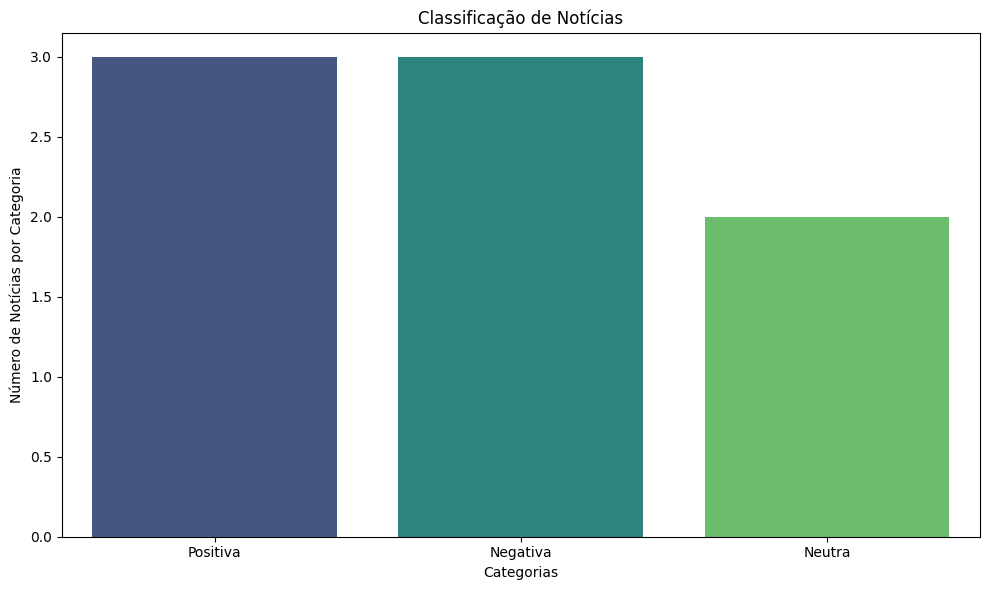

In [7]:
plt.figure(figsize=(10, 6))

# plotting
sns.barplot(data=df_news, palette='viridis')

#customizing plot
plt.xlabel('Categorias')
plt.ylabel('Número de Notícias por Categoria')
plt.title('Classificação de Notícias')

plt.tight_layout()
plt.show()

### Análise:

A partir do título das notícias, concordamos com a classificação feita pelo LLM uma vez que em nossa opinião temos três notícias positivas, duas neutras e três negativas.


## Questão 5

In [12]:
import pandas as pd

df_script = pd.read_csv('./data/theSimpsons/simpsons_script_lines.csv', low_memory=False)
df_episodes = pd.read_csv('./data/theSimpsons/simpsons_episodes.csv', low_memory=False)
df_characters = pd.read_csv('./data/theSimpsons/simpsons_characters.csv', low_memory=False)
df_locations = pd.read_csv('./data/theSimpsons/simpsons_locations.csv', low_memory=False)

df_script.set_index('id', inplace=True)
df_characters['id'] = df_characters['id'].astype(str)

df_characters = df_characters.add_prefix('character_')
df_locations = df_locations.add_prefix('location_')
df_episodes = df_episodes.add_prefix('episode_')

data = (
    df_script.merge(df_episodes, left_on='episode_id', right_on='episode_id')
             .merge(df_characters, left_on='character_id', right_on='character_id', how='left')
             .merge(df_locations, left_on='location_id', right_on='location_id', how='left')
)
data.head()

,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,...,episode_season,episode_title,episode_us_viewers_in_millions,episode_video_url,episode_views,character_name,character_normalized_name,character_gender,location_name,location_normalized_name
0,32,209,"Miss Hoover: No, actually, it was a little of ...",848000,true,464,3.0,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometim...",...,2,Lisa's Substitute,17.7,http://www.simpsonsworld.com/video/288011331912,52770.0,Miss Hoover,miss hoover,f,Springfield Elementary School,springfield elementary school
1,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,true,9,3.0,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,...,2,Lisa's Substitute,17.7,http://www.simpsonsworld.com/video/288011331912,52770.0,Lisa Simpson,lisa simpson,f,Springfield Elementary School,springfield elementary school
2,32,211,Miss Hoover: I don't know. Although I'd sure l...,856000,true,464,3.0,Miss Hoover,Springfield Elementary School,I don't know. Although I'd sure like to talk t...,...,2,Lisa's Substitute,17.7,http://www.simpsonsworld.com/video/288011331912,52770.0,Miss Hoover,miss hoover,f,Springfield Elementary School,springfield elementary school
3,32,212,Lisa Simpson: That life is worth living.,864000,true,9,3.0,Lisa Simpson,Springfield Elementary School,That life is worth living.,...,2,Lisa's Substitute,17.7,http://www.simpsonsworld.com/video/288011331912,52770.0,Lisa Simpson,lisa simpson,f,Springfield Elementary School,springfield elementary school
4,32,213,Edna Krabappel-Flanders: The polls will be ope...,864000,true,40,3.0,Edna Krabappel-Flanders,Springfield Elementary School,The polls will be open from now until the end ...,...,2,Lisa's Substitute,17.7,http://www.simpsonsworld.com/video/288011331912,52770.0,Edna Krabappel-Flanders,edna krabappel-flanders,f,Springfield Elementary School,springfield elementary school


In [19]:
data.shape

(158271, 30)

In [ ]:
X = data.dropna(subset='normalized_text').copy()
X['n_tokens'] = X.normalized_text.fillna('').apply(lambda x: len(estimar_tokens(x)))
X.shape

(132087, 31)

### Token Médio por Episódio

In [46]:
q1 = X.groupby('episode_id')['n_tokens'].sum().mean()
print(f'O número de tokens médio por episódio é de {q1:.2f}.')

O número de tokens médio por episódio é de 2606.98.


### Token Médio por Temporada

In [47]:
q2 = X.groupby('episode_season')['n_tokens'].sum().mean()
print(f'O número de tokens médio por temporada é de {q2:.2f}.')

O número de tokens médio por temporada é de 56551.46.


### Temporada com Mais Tokens

In [48]:
q3 = X.groupby('episode_season')['n_tokens'].sum()
temporada_max_tokens = q3.idxmax()
max_tokens = q3.max()
print(f'A temporada com o maior número de tokens é {temporada_max_tokens} com {max_tokens} tokens.')

A temporada com o maior número de tokens é 7 com 70418 tokens.


### Episódio com Mais Tokens

In [49]:
q4 = X.groupby('episode_id')['n_tokens'].sum()
episodio_max_tokens = q4.idxmax()
max_tokens = q4.max()
print(f'O episódio com o maior número de tokens é {episodio_max_tokens} com {max_tokens} tokens.')

O episódio com o maior número de tokens é 49 com 3454 tokens.


<Axes: ylabel='Frequency'>

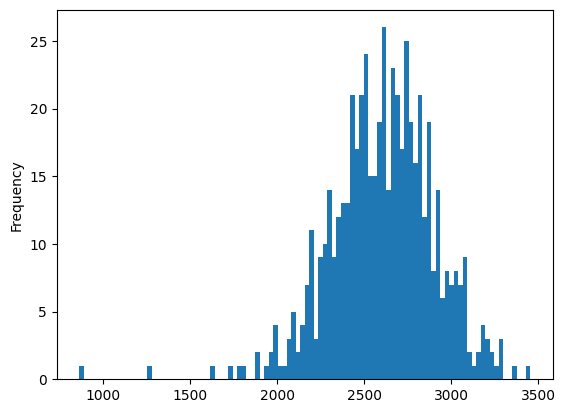

In [51]:
X.groupby('episode_id').n_tokens.sum().plot.hist(bins=100)

In [52]:
X.groupby('episode_id').n_tokens.sum().describe()

count     564.00000
mean     2606.98227
std       296.87365
min       864.00000
25%      2428.75000
50%      2619.50000
75%      2802.25000
max      3454.00000
Name: n_tokens, dtype: float64

### Análise:

A partir do histograma, observa-se que os resultados obtidos para tokens médios e máximos por episódio e temporada estão de acordo com o disposto pelos dados. Ainda é possível observar na análise e pela tabela acima que temos uma distribuição que se aproxima de uma normal, concetrada próxima de sua média, contudo com uma assimetria a esquerda que pode ser observada tanto pelo histograma quanto pelo valor de sua média que é menor que a mediana.